Import important functions and packages 

In [1]:
import sys
sys.path.insert(1, '../condensate_analysis')
import condensate_analysis as ca
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

Select your image of interest 

In [2]:
#ca.read_image should be able to read tif, czi, and nd2
file_path = "C:/Users/arrei/Documents/Documents/school/Gladfelter/F16_1257_20r_4p_.nd2"
file_name = os.path.basename(file_path)
file_name  = file_name.replace('.nd2', '')
file_name = file_name.replace('.czi', '')
img = ca.read_image(file_path)
#confirm that the file you are looking at is correct by using .shape to see the the number of channels, z coordinates, x coordinates, and y coordinates 
print(img.shape)
print(file_name)

(2, 21, 2048, 2048)
F16_1257_20r_4p_


Set protein and rna channel 

In [3]:
# set what channel is the protein channel and which channel is the RNA channel 
#remember in python the first channel is 0 and the second channel is 1 
pro_channel = 0
rna_channel = 1

Create a mask of the brightest channel and confirm water

In [4]:
# next you want to make a mask of one of the channels
# It is probably better to use the brighter of the two channels to make a mask which typically means the protein channel
# for ca.masked_image you must select which image you want to make a mask of and what channel you want to use and which slice(s) you want to use
# When selecting stack, you can set stack = "protein_max_project" or "protein_brightest_frame" in order to create a max projection or choose the brightest frame
# keeping stack = False will make sure to use the whole z stack
# you can set clear_border = True to get rid of any blobs that are cut off by the border 
# watershed is used to separate blobs that are touching
# change the watershed number to get the best separation of blobs for your data 
pro_mask,rgb = ca.mask_image(img[pro_channel,:,:,:], stack = False, clear_border=False, watershed= 5)


(-0.5, 2047.5, 2047.5, -0.5)

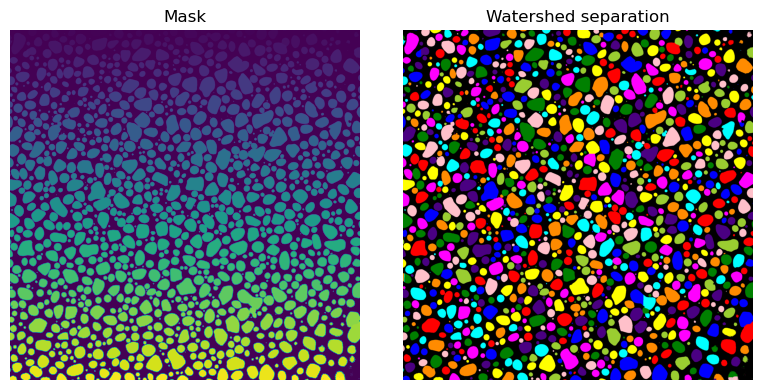

In [5]:
# you can't really visualize a 3D image so use this to so we will use a max projection to get an idea if watershed is working
pro_max = np.max(img[pro_channel, :, :, :], axis=0)
#pro_mask_max,rgb = ca.mask_image(img[pro_channel,:,:,:], stack = "protein_max_project", clear_border=False, watershed= 5)
#running into a type error when using the above where try to make a stack with ca.mask_image specifcally saying there is only one axis with 2048 pixels
pro_mask_max,rgb = ca.mask_image(pro_max, stack = False, clear_border=False, watershed= 5)
plt.figure(figsize=(12, 4), tight_layout=True)
plt.subplot(1, 3, 1)
plt.imshow(pro_mask_max)
plt.title('Mask')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(rgb)
plt.title('Watershed separation')
plt.axis('off')

Pull out the information you are looking for

In [7]:
print(pro_mask)

[[[   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]
  ...
  [   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]]

 [[   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]
  ...
  [   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]]

 [[   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]
  ...
  [   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]]

 ...

 [[   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]
  ...
  [   0 1413 1413 ...    0  848  848]
  [   0    0 1413 ...  848    0  848]
  [   0 1413 1413 ...  848  848  848]]

 [[   0    0    0 ...    0    0    0]
  [   0    0

In [9]:
#ca.featurize_image has several different features that you can select to measure and make a data frame of 
#for this function, select your image, mask, and features
# in this case I have created my own set of features I am specifically looking for 
# other features can be found in the featurize file (need to debug a bit)
# you should also be able to make your own function (need to debug a bit)
pro_info = ca.featurize_image(img[pro_channel,:,:,:], pro_mask, features=["custom_all"]) 
rna_info = ca.featurize_image(img[rna_channel,:,:,:], pro_mask, features=["custom_all"])
print(pro_info) #print info to confirm that these are the vaules you are looking for 
print(rna_info)

      label  intensity_total  centroid_info
0         1          33632.0           1052
1         2           4677.0            917
2         3          68746.0           1029
3         4           1848.0            926
4         5          59706.0           1083
...     ...              ...            ...
1414   1415       36316462.0           1480
1415   1416       17485707.0           1487
1416   1417          15437.0           1601
1417   1418       18832045.0           1119
1418   1419       11080248.0           1107

[1419 rows x 3 columns]
      label  intensity_total  centroid_info
0         1          22103.0            685
1         2           3093.0            679
2         3          47699.0            742
3         4           1244.0            589
4         5          38875.0            756
...     ...              ...            ...
1414   1415       23090024.0            946
1415   1416       11107251.0            861
1416   1417           9532.0            833
1417   

In [10]:
print(pro_info.shape)
print(rna_info.shape)

(1419, 3)
(1419, 3)


Clean up data

In [12]:
#here I am getting rid of any spots that were detected under a certain size since I am not confident that they are true blobs
filtered_pro_data = pro_info.loc[pro_info['area'] > 25] 
filtered_rna_data = rna_info.loc[pro_info['area'] > 25] 
print(filtered_pro_data.shape)
print(filtered_rna_data.shape)# see that this list is smaller than the one above 

KeyError: 'area'

Combine data

In [11]:
combined_data = filtered_pro_data
combined_data.rename(columns={'centroid_info': 'pro_centroid_int'}, inplace=True)
combined_data['rna_centroid_int'] = filtered_rna_data['centroid_info']
print(combined_data)

         area  pro_centroid_int  rna_centroid_int
0        35.0              1052               685
2        70.0              1029               742
4        59.0              1083               756
6       223.0              1302               872
8        36.0              1097               762
...       ...               ...               ...
1413  20375.0              1456               889
1414  27097.0              1480               946
1415  13779.0              1487               861
1417  17431.0              1119               706
1418  10476.0              1107               684

[1313 rows x 3 columns]


C:\Users\arrei\AppData\Local\Temp\ipykernel_11500\2058147417.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data.rename(columns={'centroid_info': 'pro_centroid_int'}, inplace=True)
C:\Users\arrei\AppData\Local\Temp\ipykernel_11500\2058147417.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data['rna_centroid_int'] = filtered_rna_data['centroid_info']


Save files as a csv

In [12]:
combined_data.to_excel(str(file_name) + '.xlsx')